In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
import glob
import time
import sys
from skimage.metrics import structural_similarity as ssim
sys.path.append("C:/Users/Alexandre/Documents/GitHub/")
# sys.path.append("C:/Users/agarcia/Documents/GitHub/custom_utils")  # Alex CRM
import utilsJ
from utilsJ.Behavior.plotting import binned_curve, tachometric, psych_curve
from utilsJ.Models import extended_ddm as exddm
from utilsJ.Models import extended_ddm_v2 as exddmv2
from utilsJ.Models.extended_ddm_v2 import com_heatmap_jordi

# SV_FOLDER = '/home/molano/Dropbox/project_Barna/ChangesOfMind/'  # Manuel
SV_FOLDER = 'C:/Users/Alexandre/Desktop/CRM/Alex/paper'  # Alex
# SV_FOLDER = '/home/jordi/DATA/Documents/changes_of_mind/'  # Jordi
# DATA_FOLDER = '/home/molano/ChangesOfMind/data/'  # Manuel
# SV_FOLDER = 'C:/Users/agarcia/Desktop/CRM/Alex/paper/'  # Alex CRM
DATA_FOLDER = 'C:/Users/Alexandre/Desktop/CRM/Alex/paper/data/'  # Alex
# DATA_FOLDER = '/home/jordi/DATA/Documents/changes_of_mind/data_clean/'  # Jordi
# DATA_FOLDER = 'C:/Users/agarcia/Desktop/CRM/Alex/paper/data/'  # Alex CRM
BINS = np.linspace(0, 300, 31)
data_augment_factor = 10

In [22]:
files = glob.glob(DATA_FOLDER+'SampleLE43'+'/sample_*')
data = np.load(files[np.random.choice(a=len(files))])
stim = data['stim']
zt = data['zt']
coh = data['coh']
com = data['com']
gt = data['gt']
sound_len = data['sound_len']
stim = exddmv2.data_augmentation(stim=stim, daf=data_augment_factor)
stim_res = 50/data_augment_factor

In [23]:
num_tr = int(5e4)
load_data = True
new_sample = False
single_run = True
shuffle = True
existing_data = None

In [24]:
compute_trajectories = True
plot = True
num_tr = stim.shape[1]
MT_slope = 0.123
MT_intercep = 254
detect_CoMs_th = 5
stim = stim[:, :int(num_tr)]
zt = zt[:int(num_tr)]
sound_len = sound_len[:int(num_tr)]
coh = coh[:int(num_tr)]
com = com[:int(num_tr)]
gt = gt[:int(num_tr)]
fixation = int(300/stim_res)

In [25]:
def get_params():
    """
    return best parameters
    """
    p_t_aff = 13
    p_t_eff = 6
    p_t_a = 14 
    p_w_zt = 0.2
    p_w_stim = 0.12
    p_e_noise = 0.03
    p_com_bound = 0.
    p_w_a = 0.03
    p_a_noise = np.sqrt(5e-3)
    p_1st_readout = 80
    p_2nd_readout = 180
    return p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout

# Index
##### 1. Simulation with good parameters
##### 2. Parameter exploration
    2.1 p_1st_readout
    2.2 p_2nd_readout
    2.3 p_t_eff
    2.4 p_t_aff
    2.5 p_t_aff + p_t_eff = 100 ms
    2.6 p_w_stim
    2.7 p_w_zt
    2.8 p_com_bound
    2.9 p_e_noise


We use rat LE43

#### Good parameters:

Text(0.5, 1.0, 'Data')

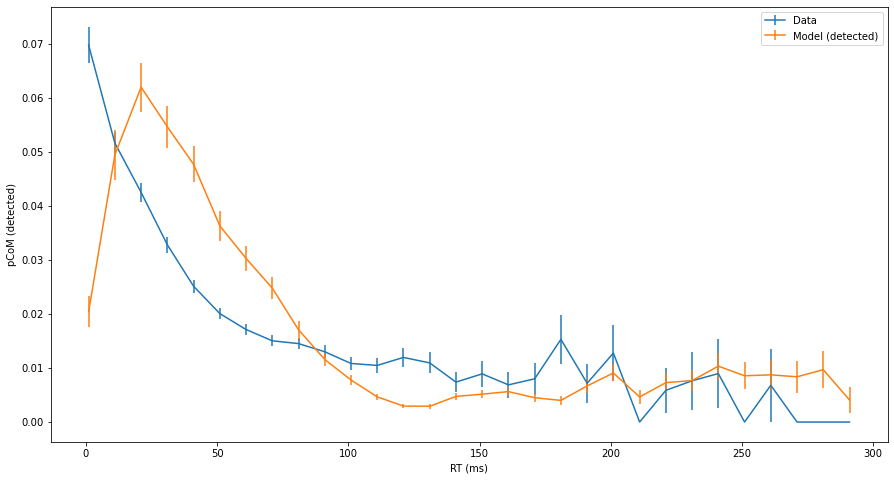

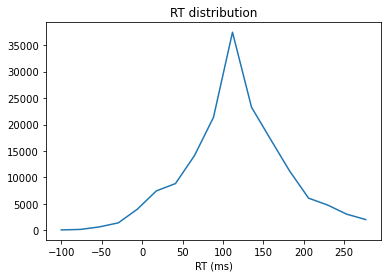

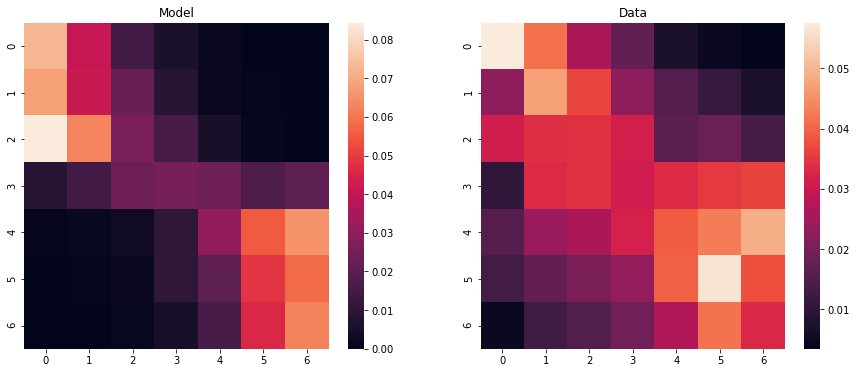

In [26]:
all_trajs = True
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
fig, ax = plt.subplots(1, figsize=(15,8))
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
rt_vals, rt_bins, tr_index  =\
    exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                            MT_slope=MT_slope, MT_intercep=MT_intercep,
                            p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                            p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                            p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                            num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                            p_2nd_readout=p_2nd_readout,
                            p_a_noise=p_a_noise,
                            compute_trajectories=compute_trajectories,
                            stim_res=stim_res, all_trajs=all_trajs)
hits = resp_fin == gt
detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
data_to_plot = {'sound_len_model': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                'first_resp': resp_first, 'final_resp': resp_fin,
                'avtrapz': coh,
                'pro_vs_re': pro_vs_re,
                'detected_com': detected_com, 'sound_len': sound_len}
df_plot = pd.DataFrame(data_to_plot)
binned_curve(df_plot, 'CoM', 'sound_len', bins=BINS, ax=ax,
             xpos=10, errorbar_kw={'label': 'Data'})
binned_curve(df_plot, 'detected_com', 'sound_len_model', bins=BINS, ax=ax,
             xpos=10, errorbar_kw={'label': 'Model (detected)'})
ax1.plot(rt_bins[:-1], rt_vals, label='Data')
matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                              return_mat=True, flip=True)
sns.heatmap(matrix, ax=ax_mat[0])
ax_mat[0].set_title('Model')
ax1.set_title('RT distribution')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend()
matrix, _ = com_heatmap_jordi(zt, coh, com,
                            return_mat=True, flip=True)
sns.heatmap(matrix, ax=ax_mat[1])
ax_mat[1].set_title('Data')

## Exploring parameters

##### Changing p_1st_readout: 1st update of the motor time. MT_1 = MT_preplanned - p_1st_readout · |evidence of first readout|

In [ ]:
all_trajs = True
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
######
# Five values between 40 and 200 (slope of the reduction of MT with evidence in the first readout, negative sign)
p_1st_readout_list = np.linspace(40, 200, num=5)
######
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
fig, ax = plt.subplots(1, figsize=(15,8))
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_1st_readout in enumerate(p_1st_readout_list):
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res, all_trajs=all_trajs)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_1st_readout, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_1st_readout, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_1st_readout: {}'.format(round(p_1st_readout, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_1st_readout:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_1st_readout:')

##### Changing p_2nd_readout: 2nd update. MT_2 = MT_1 + offset - p_2nd_readout · |1 - ( second evidence - com_bound) | 
where offset = 140 ms

In [ ]:
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
######
# Five values between 40 and 200
p_2nd_readout_list = np.linspace(40, 200, num=5)
######
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
fig, ax = plt.subplots(1, figsize=(15,8))
ax.set_ylim(0, 0.1)
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_2nd_readout in enumerate(p_2nd_readout_list):
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_2nd_readout, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_2nd_readout, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_2nd_readout: {}'.format(round(p_2nd_readout, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_2nd_readout:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_2nd_readout:')

##### Changing p_t_eff: time between the evidence/action bound hitting and the actual movement

In [ ]:
### Changing p_t_eff (it has precision of 5 ms, so a p_t_eff of 5 means 25 ms)
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
p_t_eff_list = np.linspace(5, 13, num=5)
fig, ax = plt.subplots(1, figsize=(15,8))
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_t_eff in enumerate(p_t_eff_list):
    p_t_eff = int(p_t_eff)
    stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_t_eff, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_t_eff, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_t_eff: {}'.format(round(p_t_eff, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_t_eff:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_t_eff:')

##### Changing p_t_aff: time between the start of the stimulus and the beginning of the evidence integration

In [ ]:
### Changing p_t_aff (it has precision of 5 ms, so a p_t_aff of 5 means 25 ms)
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
p_t_aff_list = np.linspace(5, 20, num=4)
fig, ax = plt.subplots(1, figsize=(15,8))
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_t_aff in enumerate(p_t_aff_list):
    p_t_aff = int(p_t_aff)
    stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_t_aff, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_t_aff, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_t_aff: {}'.format(round(p_t_aff, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_t_aff:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_t_aff:')

#### p_t_aff+ p_t_eff = constant = 100 ms

In [ ]:
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
p_t_eff_list = np.linspace(0, 20, num=5)
fig, ax = plt.subplots(1, figsize=(15,8))
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_t_eff in enumerate(p_t_eff_list):
    p_t_eff = int(p_t_eff)
    p_t_aff = int(20 - p_t_eff)
    stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_t_eff, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_t_eff, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_t_eff: {}'.format(round(p_t_eff, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_t_eff:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_t_eff:')

##### Changing p_w_stim: weight of the stimulus regarding the evidence drift (V_e): V_e = p_w_stim · stim

In [ ]:
### Changing p_w_stim
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
p_w_stim_list = np.linspace(0.05, 0.25, num=5)
fig, ax = plt.subplots(1, figsize=(15,8))
ax.set_ylim(0, 0.1)
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_w_stim in enumerate(p_w_stim_list):
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_w_stim, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_w_stim, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_w_stim: {}'.format(round(p_w_stim, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_w_stim:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_w_stim:')

##### Changing p_w_zt: weight of the prior regarding the offset (z).   z = p_w_zt · prior

In [ ]:
### Changing p_w_zt
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
p_w_zt_list = np.linspace(0.05, 0.25, num=5)
fig, ax = plt.subplots(1, figsize=(15,8))
ax.set_ylim(0, 0.1)
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_w_zt in enumerate(p_w_zt_list):
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_w_zt, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_w_zt, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_w_zt: {}'.format(round(p_w_zt, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_w_zt:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_w_zt:')

#### CoM-bound (p_com_bound): bound that the acummulated evidence has to reach to produce a change of mind

In [ ]:
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
######
# Five values between 0.1 and 0.5 (the sign is always the opposite of the first readout)
p_com_bound_list = np.linspace(0., 0.5, num=5)
######
fig, ax = plt.subplots(1, figsize=(15,8))
ax.set_ylim(0, 0.1)
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_com_bound in enumerate(p_com_bound_list):
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_com_bound, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_com_bound, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_com_bound: {}'.format(round(p_com_bound, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_com_bound:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_com_bound:')

#### Changing p_e_noise: noise of the evidence integration

In [ ]:
p_t_aff, p_t_eff, p_t_a, p_w_zt, p_w_stim, p_e_noise, p_com_bound, p_w_a, p_a_noise, p_1st_readout, p_2nd_readout = get_params()
stim_temp = np.concatenate((stim, np.zeros((p_t_aff+p_t_eff, stim.shape[1]))))
######
# Five values between 0.1 and 0.5 (the sign is always the opposite of the first readout)
p_e_noise_list = np.linspace(0.005, 0.05, num=5)
######
fig, ax = plt.subplots(1, figsize=(15,8))
ax.set_ylim(0, 0.1)
fig1, ax1 = plt.subplots(1)
fig_mat, ax_mat = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax_mat = ax_mat.flatten()
for i_ax, p_e_noise in enumerate(p_e_noise_list):
    E, A, com_model, first_ind, second_ind, resp_first, resp_fin,\
    pro_vs_re, matrix, total_traj, init_trajs, final_trajs,\
    frst_traj_motor_time, x_val_at_updt, xpos_plot, median_pcom,\
    rt_vals, rt_bins, tr_index  =\
        exddmv2.trial_ev_vectorized(zt=zt, stim=stim_temp, coh=coh,
                                MT_slope=MT_slope, MT_intercep=MT_intercep,
                                p_w_zt=p_w_zt, p_w_stim=p_w_stim,
                                p_e_noise=p_e_noise, p_com_bound=p_com_bound,
                                p_t_aff=p_t_aff, p_t_eff=p_t_eff, p_t_a=p_t_a,
                                num_tr=num_tr, p_w_a=p_w_a, p_1st_readout=p_1st_readout,
                                p_2nd_readout=p_2nd_readout,
                                p_a_noise=p_a_noise,
                                compute_trajectories=compute_trajectories,
                                stim_res=stim_res)
    hits = resp_fin == gt
    detected_com = np.abs(x_val_at_updt) > detect_CoMs_th
    data_to_plot = {'sound_len': (first_ind-fixation+p_t_eff)*stim_res, 'CoM': com,
                    'first_resp': resp_first, 'final_resp': resp_fin,
                    'avtrapz': coh,
                    'pro_vs_re': pro_vs_re,
                    'detected_com': detected_com}
    df_plot = pd.DataFrame(data_to_plot)
    binned_curve(df_plot, 'detected_com', 'sound_len', bins=BINS, ax=ax,
                 xpos=10, errorbar_kw={'label': f'{round(p_e_noise, 4)}'})
    ax1.plot(rt_bins[:-1], rt_vals, label=f'{round(p_e_noise, 4)}')
    matrix, _ = com_heatmap_jordi(zt, coh, detected_com,
                                  return_mat=True, flip=True)
    sns.heatmap(matrix, ax=ax_mat[i_ax])
    ax_mat[i_ax].set_title('p_e_noise: {}'.format(round(p_e_noise, 4)))
ax1.set_title('RT distribution')
ax1.legend(title='p_e_noise:')
ax1.set_xlabel('RT (ms)')
ax.set_ylabel('pCoM (detected)')
ax.set_xlabel('RT (ms)')
ax.legend(title='p_e_noise:')